In [10]:
from twitterscraper import query_tweets
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import seaborn as sns
import numpy as np
from textblob import TextBlob as tb
import nltk
nltk.download('brown')
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
#scrape twitter for most recent tweets on the election

n_tweets = 100
tweets = []
for tweet in query_tweets("election", n_tweets)[:n_tweets]:
    tweets.append(tweet)


In [4]:
#get the tweet text
tweet_text = list(map(lambda x: x.text, tweets))

In [42]:
#convert the data to a useable format
n_features = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tf = tf_vectorizer.fit_transform(tweet_text)
tf_feature_names = tf_vectorizer.get_feature_names()

In [57]:
#fit a topic model to the tweets
n_topics = 10
lda = LDA(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0).fit(tf)

In [59]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic ' + str(topic_idx) + ': ')
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [60]:
display_topics(lda, tf_feature_names, 10)

Topic 0: 
blasio loves com kenya http 05 october tt state status
Topic 1: 
tv days coming russia briefing election releases russian opinioncourt lose
Topic 2: 
2017 women start 2016 evidence chance said best october congress
Topic 3: 
election congress thought http shs ift rt tt acosta does
Topic 4: 
shs chance releases tories meddling ll forces pr thought doing
Topic 5: 
election say gl fb kenya weeks https opinioncourt media like
Topic 6: 
election trump said did fear pres 2016 won doing russia
Topic 7: 
election mayor vote blasio http board town hall near loves
Topic 8: 
election com twitter pic 10 http 2017 state trump timetable
Topic 9: 
election com twitter https status voter need just russian www


In [66]:
np.array(tf[0, :])

array(<1x138 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>, dtype=object)

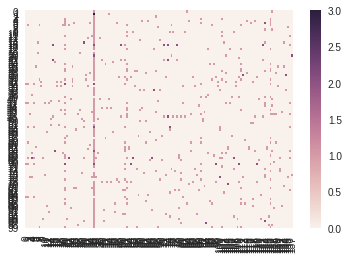

In [72]:
sns.heatmap(tf.todense())

In [5]:
blob = tb(tweet_text[0])

In [19]:
def tweet_sentiment(tweet):
    b = tb(tweet)
    return np.sum(np.array(list(map(lambda x: x.sentiment.polarity, b.sentences))))

In [21]:
sentiments = list(map(tweet_sentiment, tweet_text))

In [28]:
tweet_text[np.where(sentiments == np.max(sentiments))[0][0]]

'Kinda like how no one thought Trump would even win the presidential election. BOOM BOOM. HILLARY HAD A BIG FIREWORKS SHOW PLANNED LMAO pic.twitter.com/OvA25e0BQ2'

In [29]:
tweet_text[np.where(sentiments == np.min(sentiments))[0][0]]

'The United States officially became an IDIOCRACY last Nov. with the election of an IDIOT We now have a govt. for the idiots, by the idiots'